# M5 Categorical Features

### Replacing categorical with continuous features:

Only at level 12 we have 30490 categorical features, they take up memory and are not particularly informative. For example there is no way to figure out if the products in the categories are similar or different. If we replace categories with category descriptive features like mean, std, skew etc we can 

### Destribution features
#### Icludes aggregations by level
* sales_mean
* sales_std
* sales_skew
* days_since_start

### Metric features
* W-parameter
* S-parameter

### PRICE features
* price_std
* mean_price
* mean_price_change

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import gc

In [2]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# Define fold pass here:
file_pass = '/kaggle/input/fast-clear-wrmsse-18ms/'# '/kaggle/input/fast-wrmsse-and-sw-frame/'

# Load S and W weights for WRMSSE calcualtions:
sw_df = reduce_mem_usage(pd.read_pickle(file_pass+'sw_df.pkl'))
S = sw_df.s.values

# Load roll up matrix to calcualte aggreagates:
roll_mat_df = reduce_mem_usage(pd.read_pickle(file_pass+'roll_mat_df.pkl'))
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
#del roll_mat_df

Mem. usage decreased to  2.11 Mb (23.7% reduction)
Mem. usage decreased to 1247.46 Mb (0.0% reduction)


In [5]:
# Function to do quick rollups:
def rollup(v):
    '''
    v - np.array of size (30490 rows, n day columns)
    v_rolledup - array of size (n, 42840)
    '''
    return roll_mat_csr*v #(v.T*roll_mat_csr.T).T

### Load Datasets
All three datasets needed because we need to calculate sales in USD.

In [6]:
data_pass = '/kaggle/input/m5-forecasting-accuracy/'

# Sales quantities:
sales = pd.read_csv(data_pass+'sales_train_validation.csv')

# Calendar to get week number to join sell prices:
calendar = pd.read_csv(data_pass+'calendar.csv')
calendar = reduce_mem_usage(calendar)

# Sell prices to calculate sales in USD:
sell_prices = pd.read_csv(data_pass+'sell_prices.csv')
sell_prices = reduce_mem_usage(sell_prices)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)


# Destribution features
#### Icludes aggregations by level
* sales_mean
* sales_std
* sales_skew
* days_since_start

In [7]:
# Dummies df:
roll_mat_df = roll_mat_df.reset_index()

# Dataframe to hold categorical features:
cat_df = pd.DataFrame(index = sales.index)

In [8]:
#Rolled sales:
rolled_sales_df = pd.DataFrame(rollup(sales.iloc[:,6:].values), index=roll_index)

In [9]:
# Drop leading zeros before calculating statistics:
no_sales = np.cumsum(rolled_sales_df, axis=1) == 0
rolled_sales_df[:] = np.where(no_sales, np.nan, rolled_sales_df)

In [10]:
#Caluating rolled feature vectors:
rolled_stats_df = pd.DataFrame(index=roll_index)
rolled_stats_df['mean'] = rolled_sales_df.mean(axis=1)
rolled_stats_df['skew'] = rolled_sales_df.skew(axis=1)
rolled_stats_df['std'] = rolled_sales_df.std(axis=1)
rolled_stats_df['kurt'] = rolled_sales_df.kurtosis(axis=1)
rolled_stats_df['sale_start'] = np.argmax(~rolled_sales_df.isna().values, axis=1)
rolled_stats_df['S'] = S
rolled_stats_df['zeros']= np.nansum(np.where(rolled_sales_df.isna(), np.nan, rolled_sales_df == 0),axis=1)

In [11]:
rolled_stats_df.to_csv('rolled_stats_df_distributions.csv')

In [12]:
rolled_stats_df.head()

mean      skew          std      kurt  sale_start  \
level id                                                                
0     all   34341.562467  0.037199  7345.905196  0.713995           0   
1     CA    14989.831155  0.161639  3257.223505  0.782212           0   
      TX     9879.250392 -0.019045  1964.928938  1.119920           0   
      WI     9472.480920  0.272437  2563.314535  0.278109           0   
2     CA_1   4024.158913  0.275121   991.847206  0.161700           0   

                       S  zeros  
level id                         
0     all   3.511763e+07    0.0  
1     CA    7.341265e+06    0.0  
      TX    3.339548e+06    0.0  
      WI    3.765354e+06    0.0  
2     CA_1  7.499427e+05    5.0

# Create Categorical Dataset

In [13]:
def lvl_features(v, name, mat=roll_mat_df, idx=sales.index):
    """
    Function takes vector of length 40280
    such as mean, std or skew calculated on the
    sales dataset with aggregations 
    returns dataframe of shape 11x30490
    with columns corresponding to aggregation levels.
    """
    
    #create holder dataset:
    data = pd.DataFrame(index = sales.index)
    
    #for every level except level 0 (all products):
    for lvl in roll_mat_df.level.unique()[1:]:
        
        # mask level dummies:
        m = roll_mat_df.level == lvl
        cols = roll_mat_df.columns[2:]
        # multiply level dummies by level weights and sum row-wise:
        data[c+str(lvl)]=(roll_mat_df.loc[m,cols].values*v[m][:,None]).T.sum(axis=1)

    return reduce_mem_usage(data)

In [14]:
cat_df_list = []
for c in rolled_stats_df.columns:
    cat_df_list += [lvl_features(rolled_stats_df[c].values, c)]

Mem. usage decreased to  0.64 Mb (75.0% reduction)
Mem. usage decreased to  0.64 Mb (75.0% reduction)
Mem. usage decreased to  0.64 Mb (75.0% reduction)
Mem. usage decreased to  0.64 Mb (75.0% reduction)
Mem. usage decreased to  0.41 Mb (84.1% reduction)
Mem. usage decreased to  1.11 Mb (13.6% reduction)
Mem. usage decreased to  0.64 Mb (75.0% reduction)


In [15]:
cat_df = pd.concat(cat_df_list, axis=1)
cat_df.head()

,mean1,mean2,mean3,mean4,mean5,mean6,mean7,mean8,mean9,mean10,...,zeros2,zeros3,zeros4,zeros5,zeros6,zeros7,zeros8,zeros9,zeros10,zeros11
0,14992.0,4024.0,3202.0,2926.0,1589.0,1478.0,458.25,429.5,4.035156,2.501953,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,41.0,120.0,591.0
1,14992.0,4024.0,3202.0,2926.0,1589.0,1478.0,458.25,429.5,2.693359,0.849609,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,259.0,896.0,1368.0
2,14992.0,4024.0,3202.0,2926.0,1589.0,1478.0,458.25,429.5,1.776367,0.904785,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,211.0,390.0,592.0
3,14992.0,4024.0,3202.0,2926.0,1589.0,1478.0,458.25,429.5,20.484375,11.929688,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,13.0,23.0,581.0
4,14992.0,4024.0,3202.0,2926.0,1589.0,1478.0,458.25,429.5,8.054688,4.121094,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,51.0,193.0,838.0


In [16]:
cat_df.to_pickle('M5_F2_30490_cats.pkl')

In [17]:
#means = X_tr.groupby(col).target.mean()
#train_new[col+'_mean_target']=train_new[col].map(means)
#val_new[col+'_mean_target']= val_new[col].map[means]

# TSNE fun

In [18]:
m =[]
for c in cat_df.columns:
    if ('6' in c)|('7' in c)|('8' in c)|('9' in c)|('10' in c)|('11' in c):#('6' in c)|('7' in c)|('8' in c)|
        m += [c]

In [19]:
from sklearn.manifold import TSNE
#tsne_res = TSNE(n_components=2, verbose=0).fit_transform(cat_df.values)

tsne_res = TSNE(n_components=2, verbose=10, 
                perplexity=40, early_exaggeration=60, 
                learning_rate=150).fit_transform(cat_df[m].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 30490 samples in 0.225s...
[t-SNE] Computed neighbors for 30490 samples in 3.231s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30490
[t-SNE] Computed conditional probabilities for sample 2000 / 30490
[t-SNE] Computed conditional probabilities for sample 3000 / 30490
[t-SNE] Computed conditional probabilities for sample 4000 / 30490
[t-SNE] Computed conditional probabilities for sample 5000 / 30490
[t-SNE] Computed conditional probabilities for sample 6000 / 30490
[t-SNE] Computed conditional probabilities for sample 7000 / 30490
[t-SNE] Computed conditional probabilities for sample 8000 / 30490
[t-SNE] Computed conditional probabilities for sample 9000 / 30490
[t-SNE] Computed conditional probabilities for sample 10000 / 30490
[t-SNE] Computed conditional probabilities for sample 11000 / 30490
[t-SNE] Computed conditional probabilities for sample 12000 / 30490
[t-SNE] Computed conditional probabilities for sa

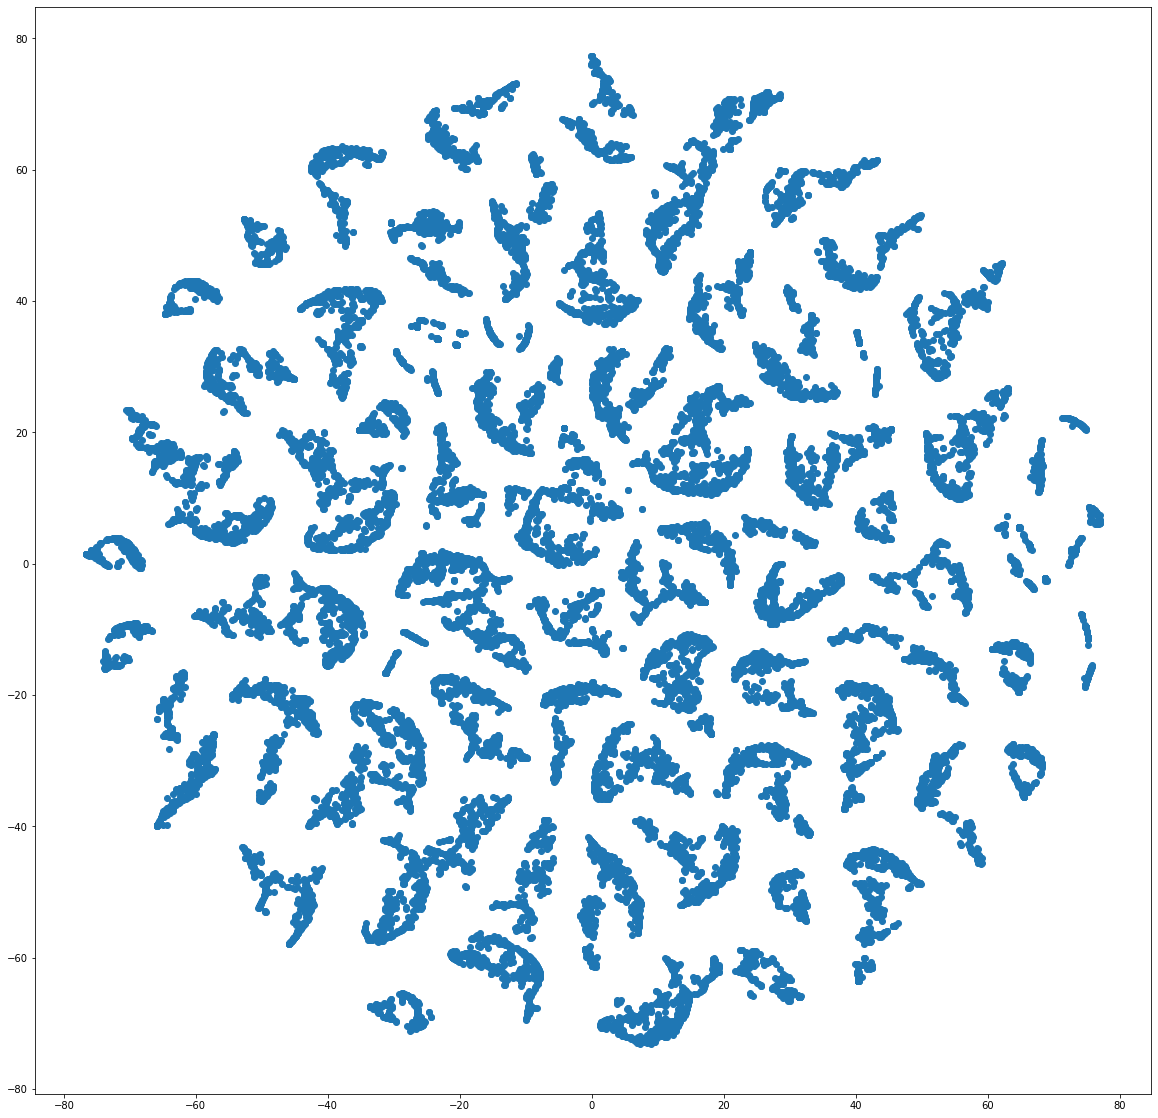

In [20]:
import matplotlib.pyplot as plt

vis_x = tsne_res[:, 0]
vis_y = tsne_res[:, 1]
plt.figure(figsize=(20,20))
plt.scatter(vis_x, vis_y);

In [21]:
# Sclae and clusterize, we use DBSCAN as it does not assume that cluster is convex:
X = StandardScaler().fit_transform(tsne_res)
db = DBSCAN(eps=0.085, min_samples=15).fit(X)

In [22]:
# Take a look at clusters' sizes:
unique, counts = np.unique(db.labels_, return_counts=True)
np.unique(counts, return_counts=True)

(array([  4,  74,  75,  76, 147, 149, 150, 186, 189, 216, 221, 326, 329,
        396, 398, 416, 515, 532, 822, 823, 824, 832]),
 array([ 1,  2,  3,  2,  1,  3,  1,  1,  1, 10,  1,  1,  1,  1,  9,  8,  8,
        10,  3,  6,  1,  1]))

In [23]:
unique

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73])

In [24]:
cluster_mask  = (counts <= 700) #& (counts >= 35)
dot_mask = np.array([(l in unique[cluster_mask]) for l in db.labels_])
np.sum(dot_mask)

21430

In [25]:
#Simple function to find centroid of a cluster:

def centroids(X, lbls):
    
    centroids = np.zeros((len(np.unique(lbls)), 2))
    
    for l in np.unique(lbls):
        mask = lbls == l
        centroids[l] = np.mean(X[mask], axis=0)
    
    return centroids

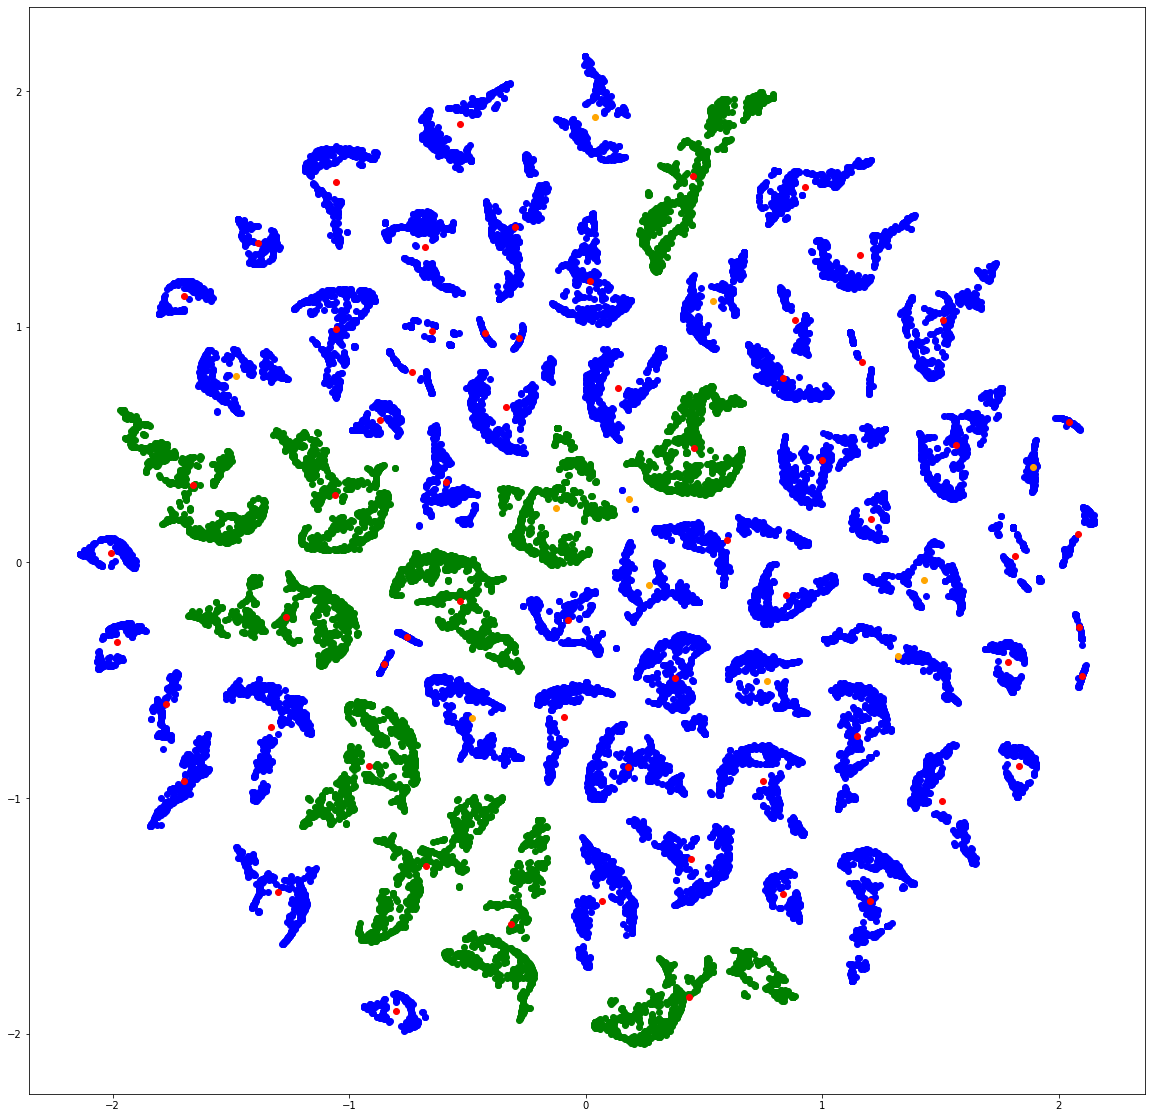

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))

# Split meaningful clusters from the noise:
plt.scatter(X[~dot_mask][:, 0], X[~dot_mask][:, 1], c='g')
plt.scatter(X[dot_mask][:, 0], X[dot_mask][:, 1], c='b')

# Add centroids to the picture:
db_centroids = centroids(X, db.labels_)
plt.scatter(db_centroids[cluster_mask][:, 0], 
            db_centroids[cluster_mask][:, 1], c='r')
plt.scatter(db_centroids[~cluster_mask][:, 0], 
            db_centroids[~cluster_mask][:, 1], c='orange')